In [57]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [59]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [60]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [61]:
tf.keras.backend.clear_session()

In [62]:
subject = 'Maranhão - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [63]:
data = pd.read_csv('2003_mo_model_input_MA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Maranhão - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,43.342,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,28.663,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,27.900,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,25.739,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,30.203,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


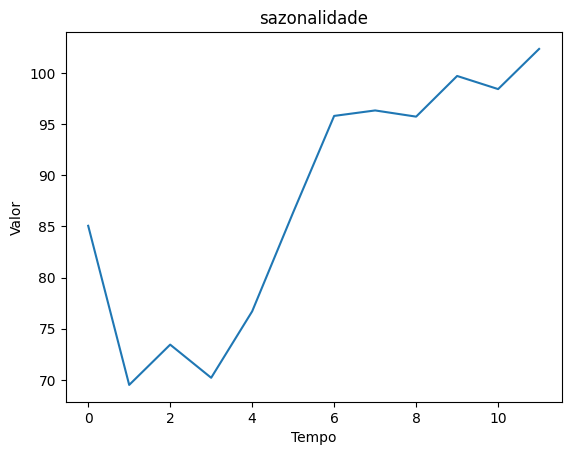

,sazonalidade
sazonalidade,
0,85.063579
1,69.500806
2,73.441280
3,70.198866
4,76.697240
5,86.370013
6,95.809232
7,96.345162
8,95.738421


In [64]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [65]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - IDH Educacao,Maranhão - IDH Renda,Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - IDH,Maranhão - PIB - Estadual,Maranhão - PIB - Construção Civil,Maranhão - PIB - Per Capita,Maranhão - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Maranhão - IDH Longevidade,sazonalidade,Maranhão - Consumo de Cimento (t)
0,2003-1,23.368400,1.609842e+06,0.614766,0.542831,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,0.635570,4.315322e+07,2.636001e+06,6.034057,3.872495e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.722204,85.063579,43.342
1,2003-2,23.167977,1.619288e+06,0.615338,0.543362,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,0.635997,4.320832e+07,2.636851e+06,6.036083,3.874405e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.722513,69.500806,28.663
2,2003-3,23.563273,1.628734e+06,0.615910,0.543892,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,0.636424,4.326343e+07,2.637701e+06,6.038110,3.876316e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.722821,73.441280,27.900
3,2003-4,24.008345,1.638180e+06,0.616483,0.544422,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,0.636851,4.331853e+07,2.638551e+06,6.040136,3.878226e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.723129,70.198866,25.739
4,2003-5,24.366896,1.647626e+06,0.617055,0.544953,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,0.637278,4.337364e+07,2.639401e+06,6.042163,3.880136e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.723438,76.697240,30.203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34913.291508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.697240,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34868.689412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.370013,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34805.943727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.809232,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34730.731162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.345162,NaN


In [66]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      56.124
1      39.810
2      44.937
3      41.661
4      47.350
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Maranhão - Consumo de Cimento (t), Length: 249, dtype: float64

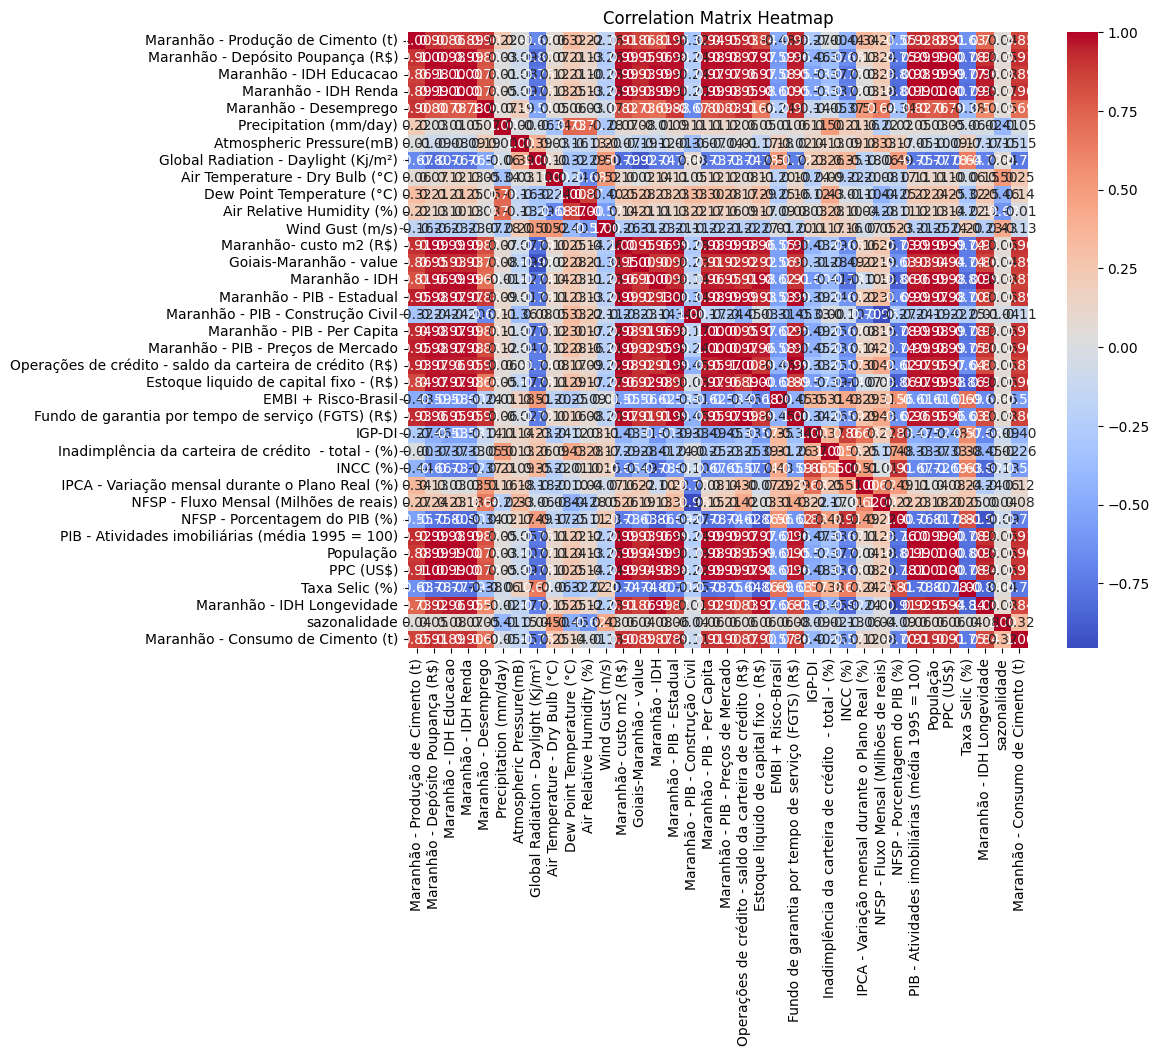

In [67]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [68]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [69]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Maranhão - Produção de Cimento (t),3.108401e+03
1,Maranhão - Depósito Poupança (R$),6.257910e+05
2,Maranhão - IDH Educacao,1.346549e+11
3,Maranhão - IDH Renda,3.501154e+09
4,Maranhão - Desemprego,4.389451e+03
5,Precipitation (mm/day),6.078388e+00
6,Atmospheric Pressure(mB),4.700552e+00
7,Global Radiation - Daylight (Kj/m²),1.048650e+02
8,Air Temperature - Dry Bulb (°C),1.919497e+02
9,Dew Point Temperature (°C),3.683572e+02


In [70]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Maranhão - Produção de Cimento (t),Maranhão - Depósito Poupança (R$),Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,23.368400,1.609842e+06,8.213662,2.330394,1005.666766,5776.461493,26.995403,22.910306,79.260234,2.399209,10548.340000,0.260097,2.636001e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,85.063579
1,23.167977,1.619288e+06,8.207986,2.330957,1005.664945,5776.461493,26.995348,22.913026,79.273296,2.397614,10647.107692,0.258964,2.636851e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,69.500806
2,23.563273,1.628734e+06,8.202310,2.331285,1005.663882,5776.461493,26.995316,22.914612,79.280916,2.396684,10736.259174,0.257352,2.637701e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,73.441280
3,24.008345,1.638180e+06,8.196633,2.331321,1005.663768,5776.461493,26.995312,22.914782,79.281732,2.396584,10818.881674,0.255929,2.638551e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,70.198866
4,24.366896,1.647626e+06,8.190957,2.397956,1005.413091,6468.525319,26.849142,22.998258,80.364896,2.323932,10897.469605,0.254109,2.639401e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,76.697240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,51.914828,4.854474e+06,12.665310,1.288704,1006.189135,1468.334368,27.157274,22.644908,77.382617,2.316530,21806.611048,0.363623,2.583734e+06,3.143856e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,390.589413,1.078474,96.345162
152,51.289460,4.847026e+06,12.684719,1.728077,1005.981043,1489.860912,27.444233,22.584345,75.789288,2.545399,21898.608848,0.364092,2.581008e+06,3.159665e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,391.798431,0.962516,95.738421
153,50.830729,4.839578e+06,12.704129,2.014852,1005.764197,1441.230577,27.557208,22.736311,75.961933,2.561887,21987.286883,0.364153,2.578281e+06,3.177292e+06,356.198303,9.630300e+06,0.447600,3.254167,0.489071,0.522000,-1243.715598,2.307250,192.810678,393.032398,1.138989,99.715948
154,50.253745,4.832130e+06,12.723538,2.240376,1005.566772,1387.378270,27.585702,22.991764,77.002234,2.475745,22077.168825,0.364197,2.575554e+06,3.192250e+06,363.318059,1.020613e+07,0.426394,3.330340,0.486059,0.509714,-1329.246736,2.242645,192.715004,394.326420,1.038436,98.432936


In [71]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Maranhão - Depósito Poupança (R$),Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.612013,-0.602776,-0.198447,0.368509,-0.123090,0.129172,-0.683019,-0.600369,0.575473,-1.621647,-0.740349,-1.023680,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.603482,-0.606008,-0.197506,0.366366,-0.123090,0.129035,-0.678718,-0.596936,0.572508,-1.593569,-0.762181,-0.997578,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.594950,-0.609240,-0.196957,0.365116,-0.123090,0.128956,-0.676209,-0.594933,0.570779,-1.568225,-0.793203,-0.971477,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.586419,-0.612472,-0.196898,0.364982,-0.123090,0.128947,-0.675940,-0.594718,0.570593,-1.544737,-0.820607,-0.945375,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.577887,-0.615704,-0.085551,0.070102,-0.024430,-0.232879,-0.543928,-0.310003,0.435542,-1.522396,-0.855647,-0.919273,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.318447,1.931989,-1.939087,0.982989,-0.737251,0.529862,-1.102728,-1.093911,0.421783,1.578854,1.252852,-2.628533,1.823582,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.398025,0.209123
152,1.311720,1.943041,-1.204905,0.738203,-0.734182,1.240196,-1.198505,-1.512726,0.847223,1.605007,1.261880,-2.712257,1.841017,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.415152,-0.182135
153,1.304993,1.954093,-0.725710,0.483120,-0.741115,1.519852,-0.958180,-1.467345,0.877873,1.630217,1.263045,-2.795980,1.860456,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.432633,0.413308
154,1.298266,1.965145,-0.348864,0.250881,-0.748792,1.590385,-0.554199,-1.193896,0.717745,1.655768,1.263890,-2.879704,1.876950,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.450965,0.074029


In [72]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Maranhão - Depósito Poupança (R$),Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.612013,-0.602776,-0.198447,0.368509,-0.123090,0.129172,-0.683019,-0.600369,0.575473,-1.621647,-0.740349,-1.023680,-1.219223,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.737578,2.007617
1,-1.603482,-0.606008,-0.197506,0.366366,-0.123090,0.129035,-0.678718,-0.596936,0.572508,-1.593569,-0.762181,-0.997578,-1.218580,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.724415,1.464013
2,-1.594950,-0.609240,-0.196957,0.365116,-0.123090,0.128956,-0.676209,-0.594933,0.570779,-1.568225,-0.793203,-0.971477,-1.218537,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.710831,2.880457
3,-1.586419,-0.612472,-0.196898,0.364982,-0.123090,0.128947,-0.675940,-0.594718,0.570593,-1.544737,-0.820607,-0.945375,-1.218044,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.696931,1.143128
4,-1.577887,-0.615704,-0.085551,0.070102,-0.024430,-0.232879,-0.543928,-0.310003,0.435542,-1.522396,-0.855647,-0.919273,-1.216487,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.683397,1.920025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.359507,1.725818,-1.479838,0.863311,-0.742643,-0.197849,-1.064782,-0.759860,0.162393,1.286625,1.131607,-1.421061,1.517172,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.245801,-0.282621
140,1.360713,1.751580,-0.924332,0.445658,-0.739475,0.227924,-1.241788,-1.114264,0.480938,1.308981,1.143264,-1.545343,1.549848,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.254608,-0.612121
141,1.361919,1.777342,-0.384527,0.188002,-0.740499,0.406201,-1.331663,-1.274092,0.540674,1.330929,1.154958,-1.669624,1.588878,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.263636,-0.137902
142,1.363125,1.803103,-0.148757,0.088456,-0.746351,0.640863,-1.297173,-1.343783,0.509902,1.353337,1.166716,-1.793906,1.625721,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.272935,-0.332143


In [73]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       56.124000
1       39.810000
2       44.937000
3       41.661000
4       47.350000
          ...    
139    105.460514
140    104.072878
141    108.366393
142    106.395263
143     91.990000
Name: Maranhão - Consumo de Cimento (t), Length: 144, dtype: float64

In [74]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [75]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 24)

In [76]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Maranhão - Depósito Poupança (R$),Maranhão - Desemprego,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Maranhão- custo m2 (R$),Goiais-Maranhão - value,Maranhão - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
108,0.663996,0.586437,0.695172,-1.021215,-0.755523,-0.223681,1.495552,1.277676,0.000569,0.790778,0.826205,0.833836,0.595959,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.812014,-1.082183
109,0.694467,0.628547,0.917699,-0.825417,-0.756607,-0.494695,2.009242,1.844884,-0.235995,0.809059,0.840065,0.780401,0.621380,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.831569,-1.036767
110,0.724938,0.670657,1.462990,-0.329052,-0.759784,-0.615167,2.453351,2.217436,-0.401635,0.827975,0.850033,0.726966,0.652999,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.850791,-0.752482
111,0.755409,0.712767,0.990611,0.053760,-0.759396,-0.598502,2.969728,2.501366,-0.471507,0.845917,0.859798,0.673532,0.685630,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.868783,-1.088413
112,0.785881,0.754877,1.086547,0.658411,-0.754448,-0.627519,2.817071,2.384803,-0.420615,0.862358,0.866972,0.620097,0.717515,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.886720,-1.508135
113,0.816352,0.796987,1.169906,1.125314,-0.746176,-0.531486,2.278039,1.879403,-0.176388,0.878158,0.873968,0.566663,0.747579,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.905151,-1.474280
114,0.846823,0.839097,1.238317,0.942365,-0.737716,-0.178806,1.623641,1.203379,0.204802,0.893935,0.884720,0.513228,0.775262,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.923702,-1.463452
115,0.877294,0.881207,0.697653,0.657961,-0.730994,0.377338,0.663918,0.268481,0.606486,0.908885,0.895397,0.459793,0.805205,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.942382,-1.236037
116,0.907766,0.923316,1.053077,0.053275,-0.731710,1.020005,0.227606,-0.390129,0.924522,0.924308,0.905291,0.406359,0.836796,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.960385,-0.935721
117,0.938237,0.965426,1.161098,-0.474467,-0.738407,1.431070,0.368548,-0.471893,0.964745,0.937226,0.913822,0.352924,0.876422,-0.900682,0.852584,-1.066619,1.618503,-0.293773,-0.110139,-0.644199,-0.639749,1.045536,0.977769,-1.241995


In [77]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [78]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [79]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [80]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [81]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3329931206, 1163964875, 843004393, 2673300809, 2358641371, 4211645154, 2605194727, 2623155149, 3410085451, 1246566391]


Step: 0 ___________________________________________
val_loss: 135.77894592285156
winner_seed: 3329931206


Step: 1 ___________________________________________
val_loss: 277.825927734375


Step: 2 ___________________________________________
val_loss: 267.3499755859375


Step: 3 ___________________________________________
val_loss: 63.151702880859375
winner_seed: 2673300809


Step: 4 ___________________________________________
val_loss: 94.97026824951172


Step: 5 ___________________________________________
val_loss: 213.57298278808594


Step: 6 ___________________________________________
val_loss: 237.05032348632812


Step: 7 ___________________________________________
val_loss: 111.7872085571289


Step: 8 ___________________________________________
val_loss: 252.0672607421875


Step: 9 ___________________________________________
val_loss: 288.7810974121094


final_s

In [82]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 394904081

Epoch 1/10000
4/4 [==============================] - 2s 119ms/step - loss: 10946.7783 - val_loss: 1878.8044
Epoch 2/10000
4/4 [==============================] - 0s 9ms/step - loss: 1031.6193 - val_loss: 145.0644
Epoch 3/10000
4/4 [==============================] - 0s 8ms/step - loss: 611.6008 - val_loss: 1020.7446
Epoch 4/10000
4/4 [==============================] - 0s 9ms/step - loss: 939.5293 - val_loss: 800.0339
Epoch 5/10000
4/4 [==============================] - 0s 9ms/step - loss: 891.7340 - val_loss: 79.0087
Epoch 6/10000
4/4 [==============================] - 0s 9ms/step - loss: 649.0394 - val_loss: 2490.2808
Epoch 7/10000
4/4 [==============================] - 0s 9ms/step - loss: 1185.4762 - val_loss: 273.1349
Epoch 8/10000
4/4 [==============================] - 0s 9ms/step - loss: 703.6997 - val_loss: 52.7285
Epoch 9/10000
4/4 [==============================] - 0s 9ms/step - loss: 920.4055 - val_loss: 107.5821
Epoch 10/10000
4/4 [==============================] - 0s 9ms/step 

Epoch 80/10000
4/4 [==============================] - 0s 9ms/step - loss: 107.4518 - val_loss: 216.3667
Epoch 81/10000
4/4 [==============================] - 0s 9ms/step - loss: 117.4857 - val_loss: 87.1934
Epoch 82/10000
4/4 [==============================] - 0s 9ms/step - loss: 89.0477 - val_loss: 163.3092
Epoch 83/10000
4/4 [==============================] - 0s 9ms/step - loss: 199.6949 - val_loss: 55.6288
Epoch 84/10000
4/4 [==============================] - 0s 8ms/step - loss: 165.6903 - val_loss: 190.9777
Epoch 85/10000
4/4 [==============================] - 0s 9ms/step - loss: 125.1214 - val_loss: 137.7544
Epoch 86/10000
4/4 [==============================] - 0s 9ms/step - loss: 95.5472 - val_loss: 83.6196
Epoch 87/10000
4/4 [==============================] - 0s 9ms/step - loss: 85.4624 - val_loss: 170.4128
Epoch 88/10000
4/4 [==============================] - 0s 9ms/step - loss: 96.6601 - val_loss: 415.7880
Epoch 89/10000
4/4 [==============================] - 0s 9ms/step - los

Epoch 159/10000
4/4 [==============================] - 0s 8ms/step - loss: 62.5250 - val_loss: 137.1125
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 61.9906 - val_loss: 119.1501
Epoch 161/10000
4/4 [==============================] - 0s 8ms/step - loss: 83.7861 - val_loss: 244.8806
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 68.0611 - val_loss: 283.8550
Epoch 163/10000
4/4 [==============================] - 0s 8ms/step - loss: 58.2587 - val_loss: 478.0793
Epoch 164/10000
4/4 [==============================] - 0s 8ms/step - loss: 105.3633 - val_loss: 209.6749
Epoch 165/10000
4/4 [==============================] - 0s 8ms/step - loss: 59.6617 - val_loss: 124.8130
Epoch 166/10000
4/4 [==============================] - 0s 7ms/step - loss: 54.2716 - val_loss: 296.6410
Epoch 167/10000
4/4 [==============================] - 0s 8ms/step - loss: 58.0106 - val_loss: 118.7430
Epoch 168/10000
4/4 [==============================] - 0s 8ms/s

4/4 [==============================] - 0s 8ms/step - loss: 49.8590 - val_loss: 190.4000
Epoch 238/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.9606 - val_loss: 348.2167
Epoch 239/10000
4/4 [==============================] - 0s 9ms/step - loss: 60.1375 - val_loss: 248.7110
Epoch 240/10000
4/4 [==============================] - 0s 9ms/step - loss: 56.7758 - val_loss: 184.5828
Epoch 241/10000
4/4 [==============================] - 0s 9ms/step - loss: 136.8066 - val_loss: 227.4790
Epoch 242/10000
4/4 [==============================] - 0s 9ms/step - loss: 62.7537 - val_loss: 92.4947
Epoch 243/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.3566 - val_loss: 333.4148
Epoch 244/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.3664 - val_loss: 301.8278
Epoch 245/10000
4/4 [==============================] - 0s 9ms/step - loss: 58.9445 - val_loss: 142.4248
Epoch 246/10000
4/4 [==============================] - 0s 9ms/step - loss: 51.07

Epoch 316/10000
4/4 [==============================] - 0s 10ms/step - loss: 43.1034 - val_loss: 95.0934
Epoch 317/10000
4/4 [==============================] - 0s 10ms/step - loss: 72.2468 - val_loss: 199.0952
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 43.3000 - val_loss: 219.5554
Epoch 319/10000
4/4 [==============================] - 0s 8ms/step - loss: 45.6016 - val_loss: 226.8832
Epoch 320/10000
4/4 [==============================] - 0s 8ms/step - loss: 41.3217 - val_loss: 200.6687
Epoch 321/10000
4/4 [==============================] - 0s 8ms/step - loss: 41.1834 - val_loss: 178.0512
Epoch 322/10000
4/4 [==============================] - 0s 8ms/step - loss: 43.7435 - val_loss: 144.0125
Epoch 323/10000
4/4 [==============================] - 0s 8ms/step - loss: 54.3363 - val_loss: 278.7120
Epoch 324/10000
4/4 [==============================] - 0s 8ms/step - loss: 49.5346 - val_loss: 183.0231
Epoch 325/10000
4/4 [==============================] - 0s 8ms/s

4/4 [==============================] - 0s 9ms/step - loss: 38.5928 - val_loss: 135.7381
Epoch 395/10000
4/4 [==============================] - 0s 9ms/step - loss: 33.8926 - val_loss: 105.2745
Epoch 396/10000
4/4 [==============================] - 0s 9ms/step - loss: 38.8684 - val_loss: 77.3840
Epoch 397/10000
4/4 [==============================] - 0s 9ms/step - loss: 54.7116 - val_loss: 200.7585
Epoch 398/10000
4/4 [==============================] - 0s 9ms/step - loss: 44.0734 - val_loss: 243.6321
Epoch 399/10000
4/4 [==============================] - 0s 9ms/step - loss: 50.0066 - val_loss: 196.7932
Epoch 400/10000
4/4 [==============================] - 0s 10ms/step - loss: 35.9105 - val_loss: 100.1741
Epoch 401/10000
4/4 [==============================] - 0s 9ms/step - loss: 42.6936 - val_loss: 184.8211
Epoch 402/10000
4/4 [==============================] - 0s 9ms/step - loss: 37.8830 - val_loss: 78.7417
Epoch 403/10000
4/4 [==============================] - 0s 8ms/step - loss: 56.121

Epoch 473/10000
4/4 [==============================] - 0s 9ms/step - loss: 32.3226 - val_loss: 104.3868
Epoch 474/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.0401 - val_loss: 155.8320
Epoch 475/10000
4/4 [==============================] - 0s 10ms/step - loss: 33.6524 - val_loss: 194.2812
Epoch 476/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.4716 - val_loss: 185.2514
Epoch 477/10000
4/4 [==============================] - 0s 9ms/step - loss: 30.3032 - val_loss: 173.1829
Epoch 478/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.7381 - val_loss: 138.2745
Epoch 479/10000
4/4 [==============================] - 0s 8ms/step - loss: 33.6528 - val_loss: 262.8588
Epoch 480/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.6866 - val_loss: 270.2296
Epoch 481/10000
4/4 [==============================] - 0s 8ms/step - loss: 35.5251 - val_loss: 223.2577
Epoch 482/10000
4/4 [==============================] - 0s 8ms/

4/4 [==============================] - 0s 8ms/step - loss: 26.8678 - val_loss: 179.8938
Epoch 552/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.2319 - val_loss: 162.9219
Epoch 553/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.4114 - val_loss: 242.5986
Epoch 554/10000
4/4 [==============================] - 0s 8ms/step - loss: 34.1906 - val_loss: 155.1248
Epoch 555/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.6874 - val_loss: 115.0783
Epoch 556/10000
4/4 [==============================] - 0s 8ms/step - loss: 25.6650 - val_loss: 201.8288
Epoch 557/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.5723 - val_loss: 202.2146
Epoch 558/10000
4/4 [==============================] - 0s 8ms/step - loss: 31.4271 - val_loss: 173.3889
Epoch 559/10000
4/4 [==============================] - 0s 9ms/step - loss: 26.6452 - val_loss: 83.7312
Epoch 560/10000
4/4 [==============================] - 0s 8ms/step - loss: 26.020

Epoch 630/10000
4/4 [==============================] - 0s 9ms/step - loss: 28.9223 - val_loss: 177.1545
Epoch 631/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.4716 - val_loss: 130.2517
Epoch 632/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.4162 - val_loss: 123.4072
Epoch 633/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.2580 - val_loss: 96.9539
Epoch 634/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.0977 - val_loss: 189.5586
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.1654 - val_loss: 114.4949
Epoch 636/10000
4/4 [==============================] - 0s 9ms/step - loss: 25.1496 - val_loss: 170.8014
Epoch 637/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.9853 - val_loss: 136.0739
Epoch 638/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.8820 - val_loss: 87.5683
Epoch 639/10000
4/4 [==============================] - 0s 8ms/step

Epoch 709/10000
4/4 [==============================] - 0s 9ms/step - loss: 23.8941 - val_loss: 217.7247
Epoch 710/10000
4/4 [==============================] - 0s 9ms/step - loss: 27.4168 - val_loss: 161.5869
Epoch 711/10000
4/4 [==============================] - 0s 9ms/step - loss: 24.8350 - val_loss: 63.1517
Epoch 712/10000
4/4 [==============================] - 0s 9ms/step - loss: 68.6993 - val_loss: 103.3371
Epoch 713/10000
4/4 [==============================] - 0s 9ms/step - loss: 31.3811 - val_loss: 117.0812
Epoch 714/10000
4/4 [==============================] - 0s 9ms/step - loss: 22.5670 - val_loss: 121.7871
Epoch 715/10000
4/4 [==============================] - 0s 8ms/step - loss: 22.4742 - val_loss: 116.3909
Epoch 716/10000
4/4 [==============================] - 0s 9ms/step - loss: 19.2306 - val_loss: 108.0295
Epoch 717/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.4997 - val_loss: 170.2453
Epoch 718/10000
4/4 [==============================] - 0s 8ms/ste

Epoch 788/10000
4/4 [==============================] - 0s 8ms/step - loss: 28.1852 - val_loss: 104.4214
Epoch 789/10000
4/4 [==============================] - 0s 8ms/step - loss: 21.3585 - val_loss: 158.4653
Epoch 790/10000
4/4 [==============================] - 0s 8ms/step - loss: 18.8158 - val_loss: 192.3769
Epoch 791/10000
4/4 [==============================] - 0s 8ms/step - loss: 22.3359 - val_loss: 114.4264
Epoch 792/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.7277 - val_loss: 140.5743
Epoch 793/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.3794 - val_loss: 155.1804
Epoch 794/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.8262 - val_loss: 108.9771
Epoch 795/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.9856 - val_loss: 130.9029
Epoch 796/10000
4/4 [==============================] - 0s 9ms/step - loss: 17.3747 - val_loss: 86.4422
Epoch 797/10000
4/4 [==============================] - 0s 9ms/st

Epoch 867/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.4544 - val_loss: 138.4904
Epoch 868/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.1814 - val_loss: 107.8474
Epoch 869/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.0029 - val_loss: 142.9048
Epoch 870/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.6445 - val_loss: 118.7804
Epoch 871/10000
4/4 [==============================] - 0s 8ms/step - loss: 15.2350 - val_loss: 132.5987
Epoch 872/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.3881 - val_loss: 88.9949
Epoch 873/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.9046 - val_loss: 86.3996
Epoch 874/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.9422 - val_loss: 125.4415
Epoch 875/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.3699 - val_loss: 134.7093
Epoch 876/10000
4/4 [==============================] - 0s 8ms/step

Epoch 946/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.5733 - val_loss: 122.5475
Epoch 947/10000
4/4 [==============================] - 0s 9ms/step - loss: 20.6908 - val_loss: 101.1180
Epoch 948/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.7846 - val_loss: 90.2715
Epoch 949/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.5367 - val_loss: 121.0974
Epoch 950/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.2516 - val_loss: 92.5359
Epoch 951/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.7655 - val_loss: 75.7417
Epoch 952/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.7902 - val_loss: 82.2021
Epoch 953/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.9680 - val_loss: 91.3265
Epoch 954/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.8146 - val_loss: 92.3773
Epoch 955/10000
4/4 [==============================] - 0s 9ms/step - 

Epoch 1025/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.8228 - val_loss: 131.7281
Epoch 1026/10000
4/4 [==============================] - 0s 8ms/step - loss: 16.0253 - val_loss: 70.5524
Epoch 1027/10000
4/4 [==============================] - 0s 8ms/step - loss: 24.6532 - val_loss: 156.4801
Epoch 1028/10000
4/4 [==============================] - 0s 8ms/step - loss: 19.6625 - val_loss: 179.9742
Epoch 1029/10000
4/4 [==============================] - 0s 8ms/step - loss: 17.1736 - val_loss: 124.9256
Epoch 1030/10000
4/4 [==============================] - 0s 8ms/step - loss: 14.9386 - val_loss: 133.1220
Epoch 1031/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.3157 - val_loss: 121.9552
Epoch 1032/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.0425 - val_loss: 106.1121
Epoch 1033/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.6900 - val_loss: 71.7031
Epoch 1034/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 8ms/step - loss: 12.9989 - val_loss: 142.9036
Epoch 1104/10000
4/4 [==============================] - 0s 8ms/step - loss: 13.4027 - val_loss: 112.1447
Epoch 1105/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.8693 - val_loss: 84.4623
Epoch 1106/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1431 - val_loss: 99.9420
Epoch 1107/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.8309 - val_loss: 103.9205
Epoch 1108/10000
4/4 [==============================] - 0s 9ms/step - loss: 16.1038 - val_loss: 103.5530
Epoch 1109/10000
4/4 [==============================] - 0s 9ms/step - loss: 15.1474 - val_loss: 109.9563
Epoch 1110/10000
4/4 [==============================] - 0s 9ms/step - loss: 14.8449 - val_loss: 195.1418
Epoch 1111/10000
4/4 [==============================] - 0s 9ms/step - loss: 18.9352 - val_loss: 133.2851
Epoch 1112/10000
4/4 [==============================] - 0s 9ms/step - loss

4/4 [==============================] - 0s 9ms/step - loss: 11.5469 - val_loss: 99.3727
Epoch 1182/10000
4/4 [==============================] - 0s 8ms/step - loss: 12.4584 - val_loss: 105.9284
Epoch 1183/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.9762 - val_loss: 105.1051
Epoch 1184/10000
4/4 [==============================] - 0s 9ms/step - loss: 12.7255 - val_loss: 132.9333
Epoch 1185/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.4696 - val_loss: 104.0369
Epoch 1186/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.8746 - val_loss: 127.5342
Epoch 1187/10000
4/4 [==============================] - 0s 9ms/step - loss: 11.7376 - val_loss: 123.6602
Epoch 1188/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.7307 - val_loss: 104.0025
Epoch 1189/10000
4/4 [==============================] - 0s 9ms/step - loss: 13.1623 - val_loss: 156.6423
Epoch 1190/10000
4/4 [==============================] - 0s 9ms/step - l

In [83]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [84]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,92.26152,90.511246,90.143661,90.592865,90.119347,89.670662,92.000809,95.670235,92.356277,92.51326,90.802071,90.319183
Target,87.564,66.661,78.801,67.256,84.28,86.501,88.78,86.195,84.121,88.187,79.514,74.061
Error,4.697517,23.850243,11.342659,23.336868,5.839348,3.169662,3.22081,9.475235,8.235275,4.326263,11.288071,16.258186


In [85]:
display(mae)
display(mape)

10.4200115

0.13857792

In [86]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [87]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[1096.961]] - Target[971.921]| =  Error: [[125.04004]]; MAPE:[[0.12865247]]


[array([[125.04004]], dtype=float32)]

125.04004

0.12865247